# Predict and evaluate timeseries models

In [1]:
import warnings; 
warnings.simplefilter('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVC

from typing import Dict, List
from prophet import Prophet

import plotly.graph_objects as go

from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Load data

In [2]:

# Load and prepare data
data_all_years = pd.read_csv('Product_SubGroup_Date_2022-2025.csv')
data_all_years['Date'] = pd.to_datetime(data_all_years['Date'])



## Functions

In [3]:
# --- MAPE calculation ---
def calculate_mape(actual, forecast):
    mask = actual != 0
    return (abs((actual[mask] - forecast[mask]) / actual[mask])).mean() * 100

# --- Forecast functions ---
def forecast_arima(train, test, lam):
    model = ARIMA(train['Quantity_Boxcox'], order=(1, 1, 12)).fit()
    boxcox_forecasts = model.forecast(len(test))
    return inv_boxcox(boxcox_forecasts, lam)

def forecast_sarima(train, test):
    model = SARIMAX(
        train['Quantity'],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    return model.forecast(len(test))

def forecast_prophet(train, test):
    prophet_df = train[['Date', 'Quantity']].rename(columns={'Date': 'ds', 'Quantity': 'y'})
    model = Prophet(daily_seasonality=True, weekly_seasonality=False)
    model.fit(prophet_df)
    future = pd.DataFrame({'ds': test['Date'].values})
    forecast = model.predict(future)
    return forecast['yhat']

def plot_forecasts_with_mape_per_group(dates, actual, arima, sarima, prophet, mape_vals, subgroup):
    plt.figure(figsize=(14, 6))

    # Plot actual and forecasts
    plt.plot(dates, actual, label='Actual', color='black', linewidth=2)
    plt.plot(dates, arima, label=f'ARIMA (MAPE: {mape_vals["ARIMA"]:.2f}%)', linestyle='--')
    plt.plot(dates, sarima, label=f'SARIMA (MAPE: {mape_vals["SARIMA"]:.2f}%)', linestyle='--')
    plt.plot(dates, prophet, label=f'Prophet (MAPE: {mape_vals["Prophet"]:.2f}%)', linestyle='--')

    # Decorate
    plt.title(f'Forecast Comparison for Product_SubGroup {subgroup}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Forecast for every product

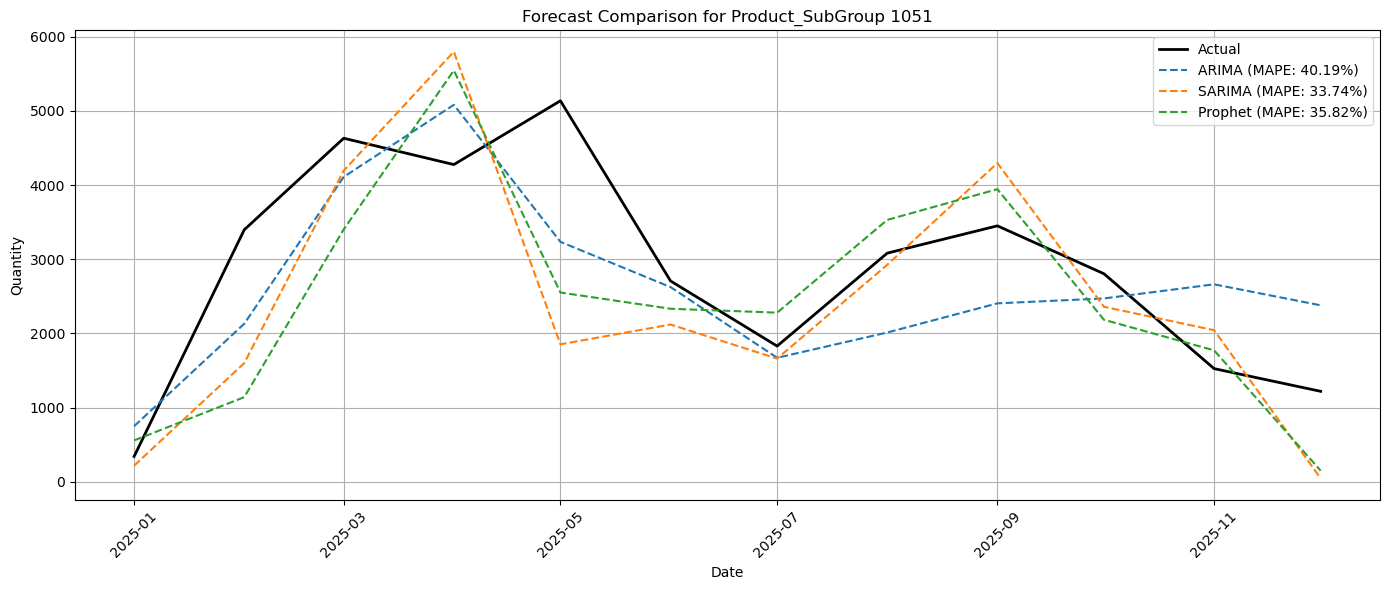

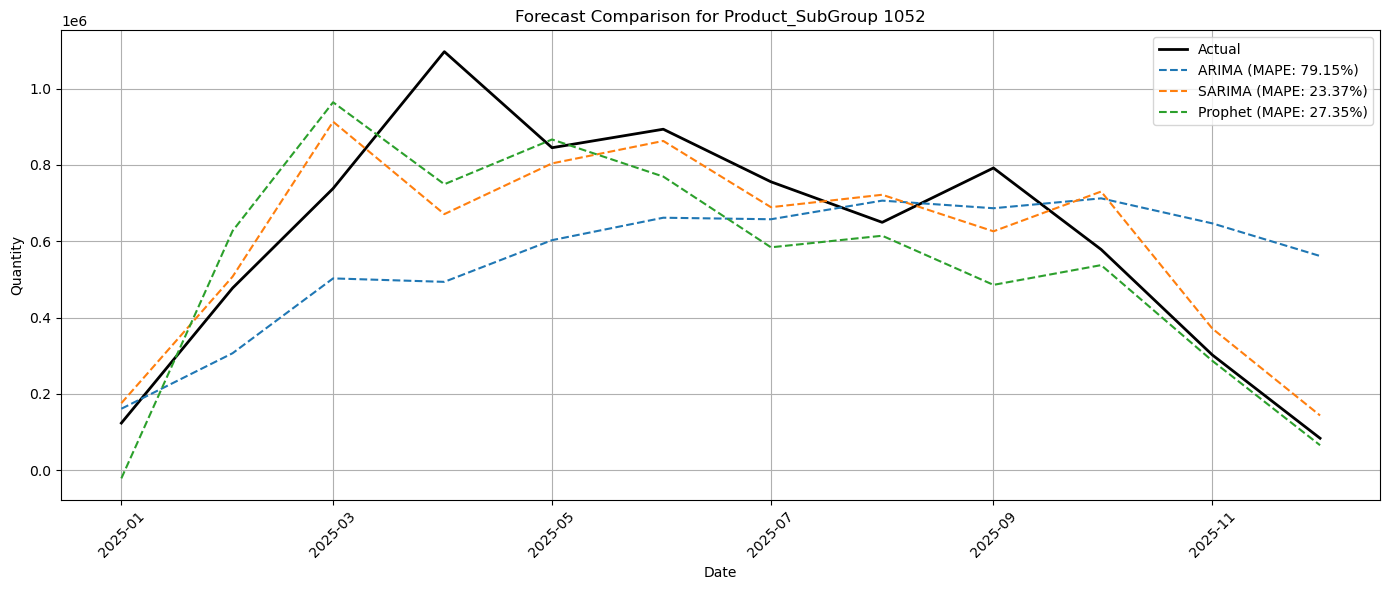

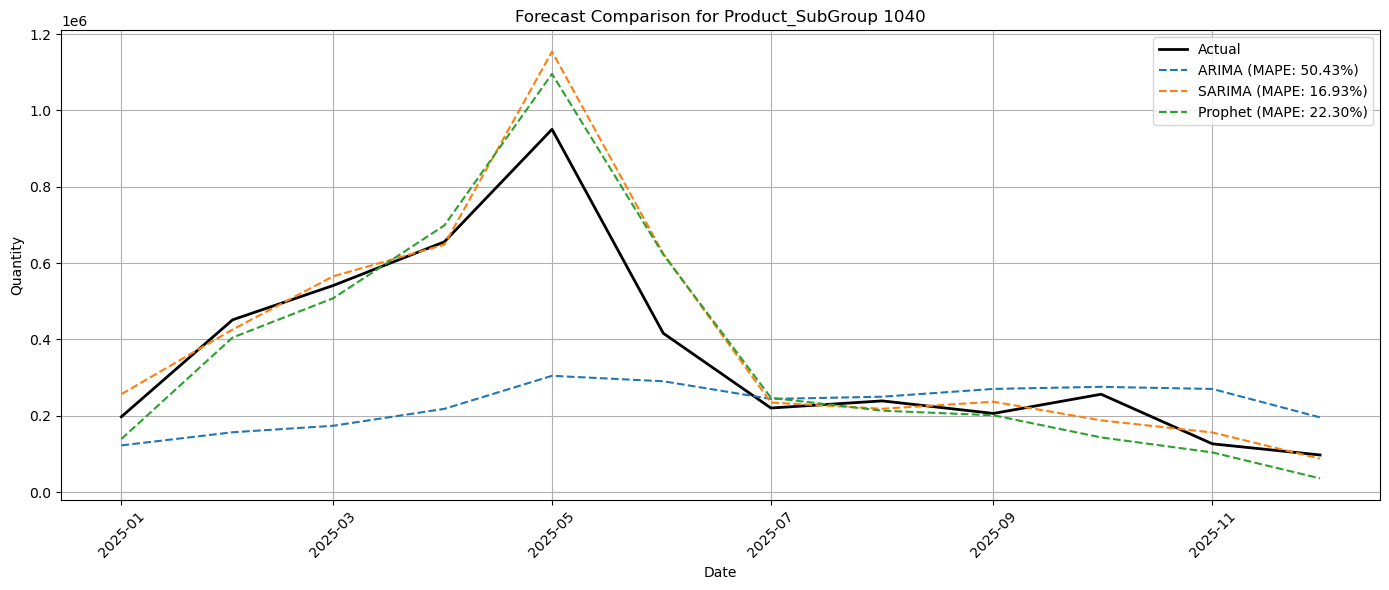

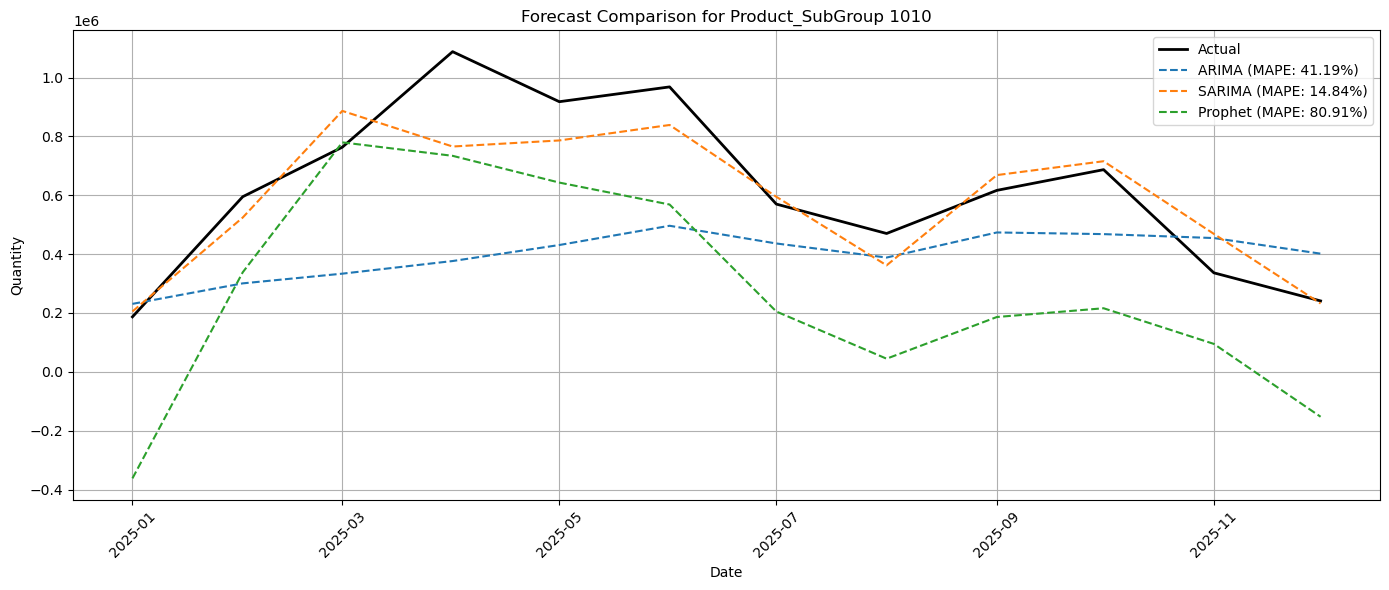

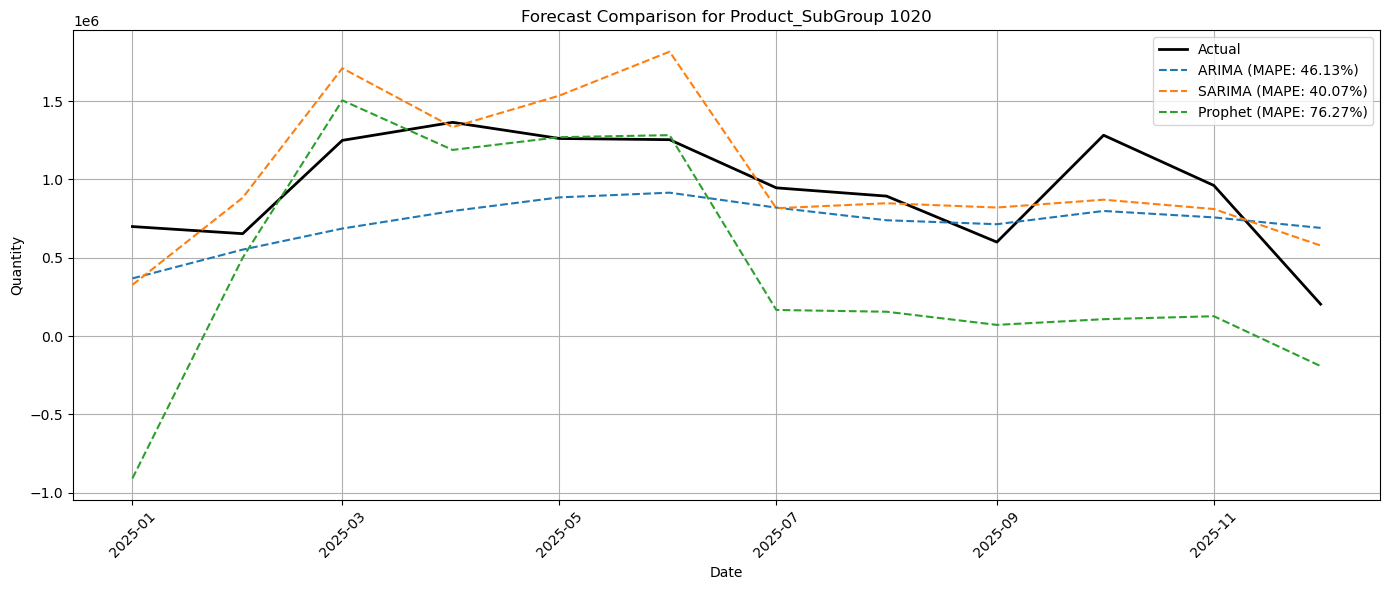

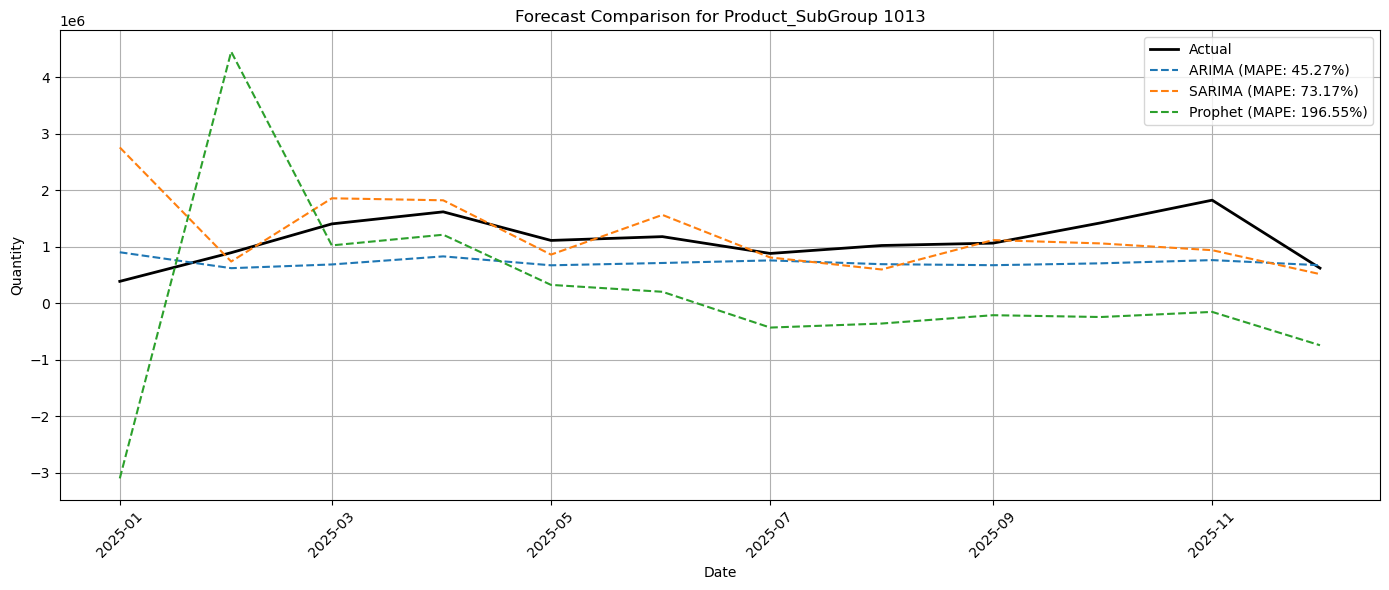

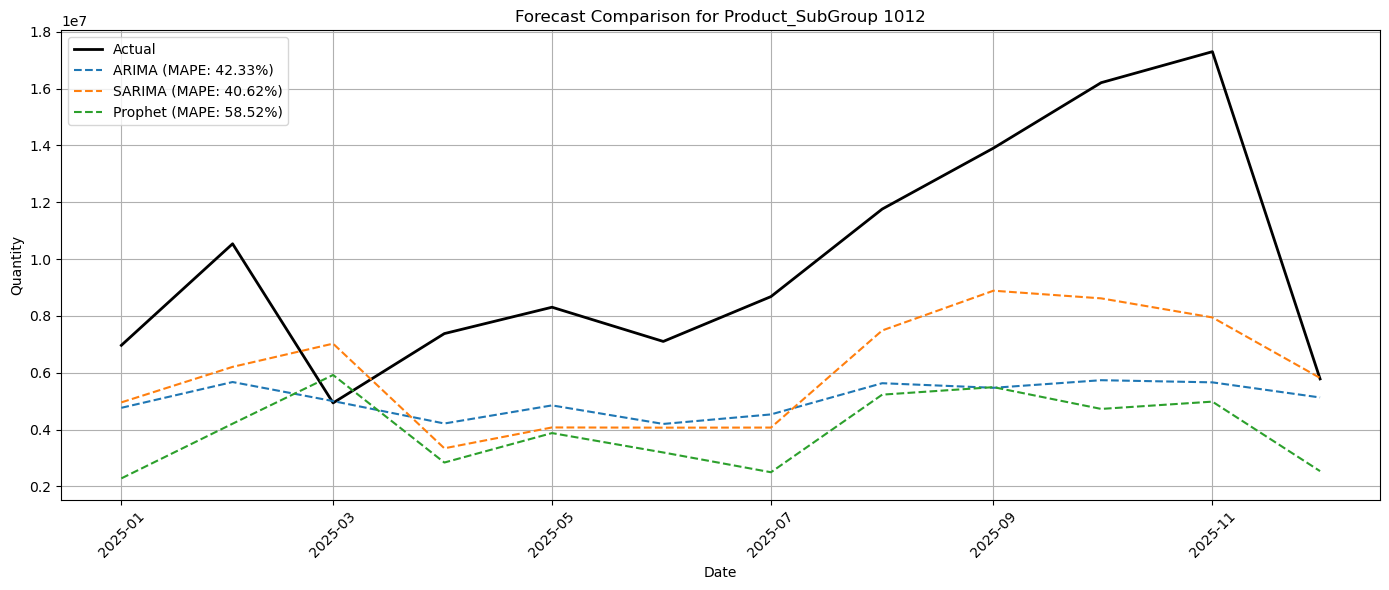

   Product_SubGroup  MAPE_ARIMA  MAPE_SARIMA  MAPE_Prophet
0              1051       40.19        33.74         35.82
1              1052       79.15        23.37         27.35
2              1040       50.43        16.93         22.30
3              1010       41.19        14.84         80.91
4              1020       46.13        40.07         76.27
5              1013       45.27        73.17        196.55
6              1012       42.33        40.62         58.52


In [4]:
# --- Loop over subgroups ---
mape_summary = []

for subgroup in data_all_years['Product_SubGroup'].unique():
    data = data_all_years[data_all_years['Product_SubGroup'] == subgroup].copy()

    # Clean
    data = data.sort_values('Date')
    if (data['Quantity'] <= 0).any():
        data['Quantity'] = data['Quantity'].apply(lambda x: x + 1e-6 if x <= 0 else x)

    # Box-Cox
    data['Quantity_Boxcox'], lam = boxcox(data['Quantity'])

    # Split
    split_idx = int(len(data) * 0.75)
    train = data.iloc[:split_idx]
    test = data.iloc[split_idx:]

    # Skip if too small to split
    if len(train) < 24 or len(test) < 12:
        continue

    # Forecasts
    try:
        arima_forecast = forecast_arima(train, test, lam)
        sarima_forecast = forecast_sarima(train, test)
        prophet_forecast = forecast_prophet(train, test)

        # MAPE
        actual = test['Quantity'].values
        mape_arima = calculate_mape(actual, arima_forecast)
        mape_sarima = calculate_mape(actual, sarima_forecast)
        mape_prophet = calculate_mape(actual, prophet_forecast)

        # Store
        mape_summary.append({
            'Product_SubGroup': subgroup,
            'MAPE_ARIMA': round(mape_arima, 2),
            'MAPE_SARIMA': round(mape_sarima, 2),
            'MAPE_Prophet': round(mape_prophet, 2)
        })
        
        plot_forecasts_with_mape_per_group(
            dates=test['Date'].values,
            actual=actual,
            arima=arima_forecast,
            sarima=sarima_forecast,
            prophet=prophet_forecast,
            mape_vals={
                "ARIMA": mape_arima,
                "SARIMA": mape_sarima,
                "Prophet": mape_prophet
            },
            subgroup=subgroup
        )
    except Exception as e:
        print(f"Error with subgroup {subgroup}: {e}")

# Final result table
mape_table = pd.DataFrame(mape_summary)

print(mape_table)



## Save model evaluation to file

In [5]:
# Save cluster file
mape_table[['Product_SubGroup', 'MAPE_ARIMA', 'MAPE_SARIMA', 'MAPE_Prophet']].to_excel('T3_mape_summary_by_product.xlsx', index=False)
print("✅ MAPE summary data saved.")



✅ MAPE summary data saved.
